# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [307]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
from sklearn.cluster import KMeans
% matplotlib inline

In [193]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Data Exploration

In [194]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [195]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [196]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


The transcript dataset is one we definitely are going to need to clean up a little bit. I will start by extracting the offer id, amount and rewards fields from the value field into its own columns for use later.

In [197]:
# Clean transcript dataset to extract the offer id, amount and reward fields from the value field

# Function to update offer id
def update_offerid(value): 
    '''
    INPUT: 
    value - (list) the value field containing offer id for offer related records
    
    OUTPUT:
    item - (string) the alphanumeric id for the offer
    
    Description:
    Extracts and returns the offer id from the value field 
    
    '''
    if 'offer id' in value:
        item = value.get('offer id')
    else:
        item = value.get('offer_id')
    return item

# Function to update amount
def update_amount(value):
    '''
    INPUT: 
    value - (list) the value field containing amount for transaction related records
    
    OUTPUT:
    item - (float) the transaction amount
    
    Description:
    Extracts and returns the amount from the value field 
    
    '''
    item = value.get('amount')
    return item

# Function to update user reward
def update_userreward(value):
    '''
    INPUT: 
    value - (list) the value field containing reward for offer completion records
    
    OUTPUT:
    item - (int) number of reward points
    
    Description:
    Extracts and returns the reward from the value field 
    
    '''
    item = value.get('reward')
    return item

# Create a new dataframe and apply the update functions
transcript_clean = transcript.copy()
transcript_clean['offer_id'] = transcript_clean['value'].apply(update_offerid)
transcript_clean['amount'] = transcript_clean['value'].apply(update_amount)
transcript_clean['user_reward'] = transcript_clean['value'].apply(update_userreward)

In [198]:
transcript_clean.head()

,event,person,time,value,offer_id,amount,user_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [199]:
# Check for any nulls in transcript_clean dataset
for c in transcript_clean.columns.values:
    print(c,': ', transcript_clean[c].isnull().sum())

event :  0
person :  0
time :  0
value :  0


CHANNEL ANALYSIS AND THEIR INFLUENCE ON OFFER COMPLETION RATES

For this analysis, we will be looking at all offers completed from the transcript dataset and matching them against the portfolio datasets to see which channels those offers came from.

In [200]:
# Check for nulls in portfolio dataset
for c in portfolio.columns.values:
    print(c,': ', portfolio[c].isnull().sum())

channels :  0
difficulty :  0
duration :  0
id :  0
offer_type :  0
reward :  0


In [201]:
# Get all offer ids for completed offers from transcript

pd.options.mode.chained_assignment = None

completed_offers = transcript_clean[transcript_clean['event'] == 'offer completed']
channels_df = portfolio[portfolio['id'].isin(completed_offers['offer_id'])]

# Function to update channel based on the list values
def update_channel(c):
    '''
    INPUT: 
    c - (string) the channel name - email, web, social or mobile
    
    OUTPUT:
    None
    
    Description:
    Creates and updates channel columns for each channel with a boolean value
    
    '''
    channels_df[c] = channels_df['channels'].apply(lambda x: 1 if c in x else 0)

channel_list = ['email','social','mobile','web']
for c in channel_list:
    update_channel(c)

channels_df

,channels,difficulty,duration,id,offer_type,reward,email,social,mobile,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [202]:
# Explore channels by offer types
channels_df.groupby(['offer_type']).agg({'email':'sum','mobile':'sum','social':'sum','web':'sum'})

,email,mobile,social,web
offer_type,,,,
bogo,4,4,3,3
discount,4,3,2,4


ANALYSIS RESULTS

There are only 8 completed offers so there isn't much data here, but from what we see, every offer has been sent via email, which is the most common channel overall. Social is the least common channel. Similar results are observed when looking at the data broken down by offer type as well.

This analysis would be more effective with a larger number of offers in the dataset, so not drawing any conclusions here.

ANALYSIS OF OFFER TYPES TO UNDERSTAND IMPACT ON VIEWING AND COMPLETION OF OFFERS

We will be looking at how receiving, viewing and completion of offers differs by offer types - bogo, discount and informational.

For this analysis, we will start by creating a dataframe out of the transcript_clean dataset that contains records for each person and offer id, if they received, viewed and/or completed the offer. We will be removing any records pertaining to purchases since for this analysis, we will be looking at offer completions primarily. 

In [203]:
# Create offer dataframe as a subset of transcript 
user_offers = transcript_clean[['event','person','offer_id']]

# Remove all purchase transactions
user_offers = user_offers[user_offers['event'] != 'transaction']
user_offers.head()

,event,person,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0


In [204]:
# Create a new consolidated dataframe with columns that denote offer received, viewed and completed for every person and offer id
user_offers_clean_columns = ['person', 'offer_id', 'offer_recd', 'offer_viewed', 'offer_comp']
user_offer_list = []

unique_person_offer = user_offers.groupby(['person','offer_id']).size().reset_index().rename(columns={0:'count'})

for index, row in unique_person_offer.iterrows():
    viewed_flag = 0
    recd_flag = 0
    comp_flag = 0
    filtered_rows = user_offers[(user_offers['person'].isin([row['person']])) & (user_offers['offer_id'].isin([row['offer_id']]))]
    for e in filtered_rows['event']:
        if 'offer received' in e:
            recd_flag = 1
        elif 'offer viewed' in e:
            viewed_flag = 1
        else: 
            comp_flag = 1

    user_offer_list.append([row['person'], row['offer_id'], recd_flag, viewed_flag, comp_flag])

user_offers_clean = pd.DataFrame(user_offer_list, columns=user_offers_clean_columns)
user_offers_clean.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1


In [206]:
# Function to update offer type based on offer id
def update_offer_type(offerid):
    '''
    INPUT: 
    offerid - (string) the alphanumeric id for an offer
    
    OUTPUT:
    offer_type - (string) offer type for a particular offer - bogo, information or discount
    
    Description:
    Returns the offer type for a particular offer id 
    
    '''
    df = portfolio[portfolio['id'] == offerid]
    return df['offer_type'].values[0]

# Create a new column for offer type and update it from portfolio
user_offers_clean['offer_type'] = user_offers_clean['offer_id'].apply(update_offer_type)
user_offers_clean.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,informational
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,informational
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount


In [207]:
# Explore offer counts by offer type
user_offers_clean.groupby('offer_type')['offer_id'].nunique()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

In [313]:
# Explore offer received, viewed and completion numbers by offer type
offer_type_df = user_offers_clean.groupby(['offer_type'])['offer_recd','offer_viewed','offer_comp'].sum().reset_index()
offer_type_rates = offer_type_df.copy()
offer_type_rates['comp_rate'] = offer_type_rates['offer_comp']/offer_type_rates['offer_recd'] * 100
offer_type_rates['view_rate'] = offer_type_rates['offer_viewed']/offer_type_rates['offer_recd'] * 100
offer_type_rates.head()


,offer_type,offer_recd,offer_viewed,offer_comp,comp_rate,view_rate
0,bogo,25321,21546,13587,53.659018,85.091426
1,discount,25316,18280,15409,60.866646,72.207300
2,informational,12651,9309,0,0.000000,73.583116


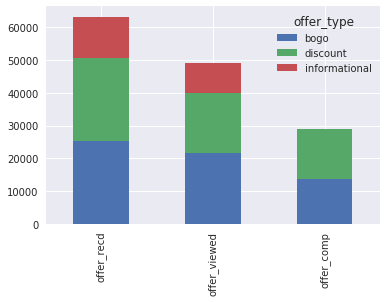

In [314]:
# Visualize offer received, viewed and completion numbers by offer type
sns.set()
offer_type_df.set_index('offer_type').T.plot(kind='bar', stacked=True);

ANALYSIS RESULTS

Based on the above, we can see that even though almost the same amount of bogo and discount offers are received, bogo offers are viewed much more than discount offers. Bogo offers have an 85% viewing rate vs. discount offers which have a 72% viewing rate. 

It is also interesting to note that even though the viewing rates are better with bogo, the completion rates are much better for discount offers. For bogos, 53.6% of offers received were completed, whereas for discounts, 60.8% of offers received were completed.

Viewing rates are better for bogos at 85% compared to discounts at 72%. Informational offers have a 73.5% viewing rate. 

Based on this analysis, you could consider the following approches:

- Consider making bogos more attractive such as personalizing based on consumer previous purchase behavior for example to increase completion rates, since the viewing rates are definitely pretty good for these offer types
- Consider making the discount offers more visually appealing and/or make the messaging more relevant and eye-catching to increase viewing rates 

ANALYSIS OF USER GROUPS TO UNDERSTAND IMPACT ON VIEWING AND COMPLETION OF OFFERS

Next, we will be analyzing the demographics (age, gender, income) of 4 different groups:

1. Users that receive offers, view offers and complete offers 
2. Users that receive offers, view offers and DO NOT complete offers
3. Users that receive offers and DO NOT view offers and DO NOT complete offers
4. Users that receive offers and DO NOT view offers and complete offers

We will be using the user_offers_clean dataframe built previously. We will start out by looking at the profile dataset further to check if it requires any cleansing. 

Since completion is an important consideration for our analysis, we will be removing 'information' offers from this analysis, since 'informational' offers can only be received and viewed, but not completed. 


In [315]:
# Check for nulls in portfolio dataset
for c in profile.columns.values:
    print(c,': ', profile[c].isnull().sum())

age :  0
became_member_on :  0
gender :  2175
id :  0
income :  2175


In [317]:
# Explore a few records that have gender as null
profile[profile['gender'].isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [316]:
profile[profile['age'] == 118].shape[0]

2175

Based on the above results, it looks like the profile dataset could use some cleaning up. There are 2175 records that have both the gender and income fields as null and from a quick preview of these records, it seems like these records with null values all have age 118 associated with them. Since a lot of our analysis will be based on demographics, and these records have no significant demographic attributes associated with them, I have decided to drop these records, so as to not skew my analysis.

Since we will be dropping these person ids, I will also drop any offer related records from a copy of the user_offers_clean dataframe to keep these 2 datasets consistent.

In [212]:
# Drop profile records that have age 118, thereby dropping all records with gender and income as Nans
profile_clean = profile[profile['age'] < 118]
profile_clean.shape

(14825, 5)

In [213]:
# Drop person id records from transcript that are not in profile
demo_df = user_offers_clean.copy()
demo_df = demo_df[demo_df['person'].isin(profile_clean['id'])]
demo_df.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,informational
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,informational
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount


In [214]:
# Remove informational offer types
demo_df = demo_df[demo_df['offer_type']!= 'informational']
demo_df.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,discount
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,discount


In [215]:
# Function to get unique profiles based on offer received, viewed and completion criteria
def get_profiles(df, recd, viewed, comp):
    '''
    INPUT: 
    df - (pandas dataframe) the dataframe containing demographic data for users
    recd - (bool) 1 for offer received, 0 for offer not received
    viewed - (bool) 1 for offer viewed, 0 for offer not viewed
    comp - (bool) 1 for offer completed, 0 for offer not completed
    
    OUTPUT:
    unique_profiles - (pandas dataframe) the dataframe containing unique profiles meeting the offer response criteria
    
    Description:
    Extracts and returns unique profiles meeting the offer response criteria 
    
    '''
    filtered_df = df[(df['offer_recd'] == recd) & 
                          (df['offer_viewed'] == viewed) & (df['offer_comp'] == comp)]

    # Get unique person ids
    unique_person_ids = filtered_df['person'].unique()

    unique_profiles = profile_clean[profile_clean['id'].isin(unique_person_ids)]
    
    return unique_profiles

# Function to visualize age, gender and income distributions
def show_plots(unique_profiles):
    '''
    INPUT: 
    unique_profiles - (pandas dataframe) the dataframe containing unique profiles with demographics
    
    OUTPUT:
    None
    
    Description:
    Plots age, gender and income distributions
    
    '''
    f1 = plt.figure(figsize=(64,8))
    axis1 = f1.add_subplot(234)
    axis1.title.set_text('Age Distribution')
    sns.countplot(unique_profiles['age'])
    plt.axvline(unique_profiles['age'].mean(), color='k', linestyle='dashed', linewidth=1)

    f2 = plt.figure(figsize=(64,8))
    axis2 = f2.add_subplot(234)
    axis2.title.set_text('Gender Distribution')
    sns.countplot(unique_profiles['gender'])

    f3 = plt.figure(figsize=(64,8))
    axis3 = f3.add_subplot(234)
    axis3.title.set_text('Income Distribution')
    sns.countplot(unique_profiles['income'])
    axis3.set_xticklabels(axis3.get_xticklabels(), rotation=40, ha="right", fontsize=7)

    plt.show()

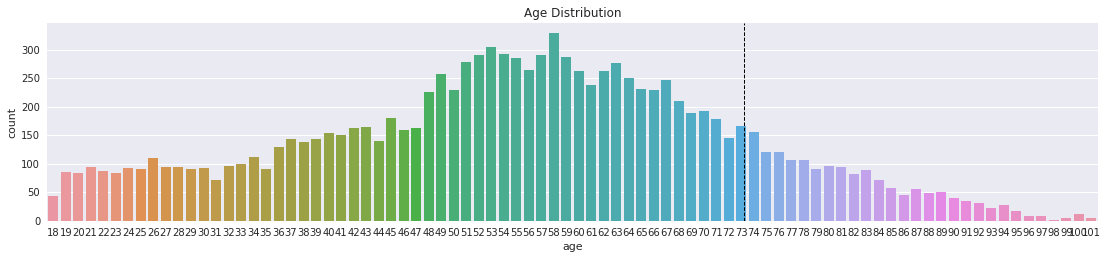

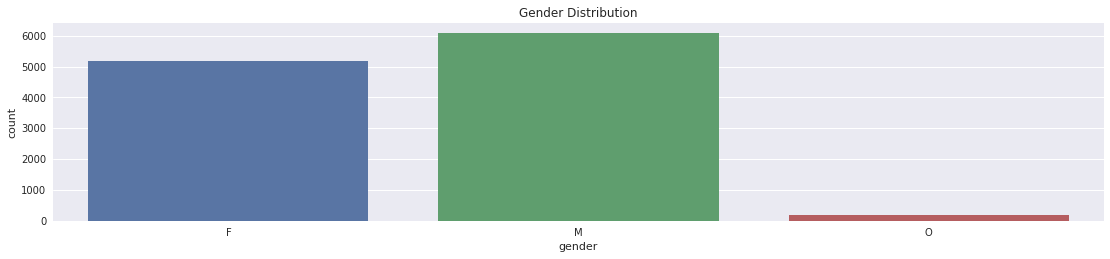

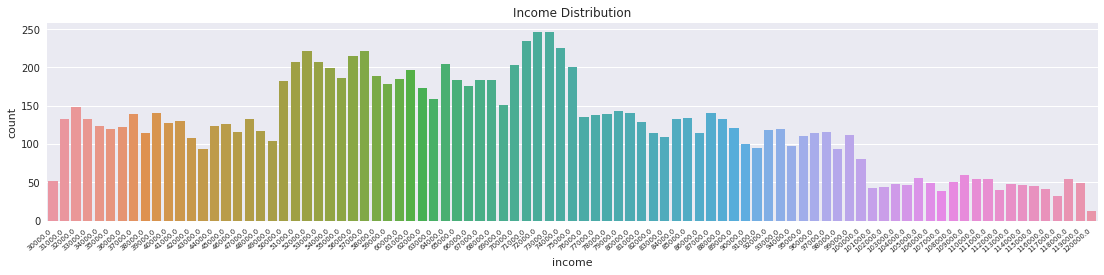

In [216]:
# Analyze Group 1 - Users that receive offers, view offers and complete offers 
unique_profiles_group1 = get_profiles(demo_df, 1, 1, 1)
show_plots(unique_profiles_group1)

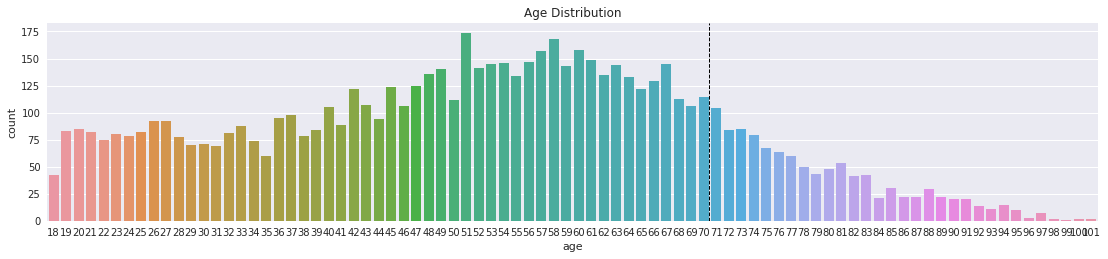

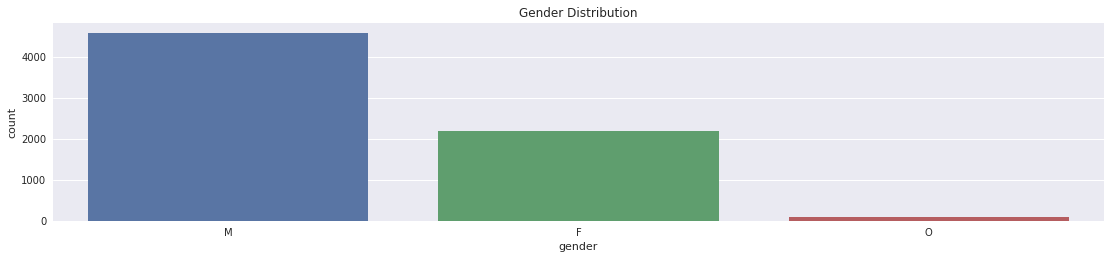

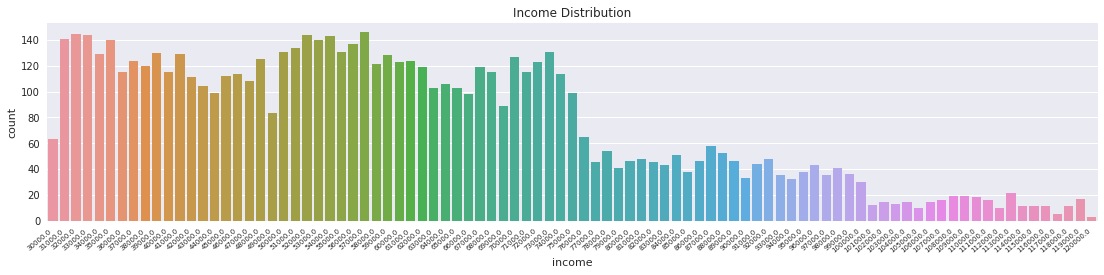

In [217]:
# Analyze Group 2 - Users that receive offers, view offers and DO NOT complete offers
unique_profiles_group2 = get_profiles(demo_df, 1, 1, 0)
show_plots(unique_profiles_group2)

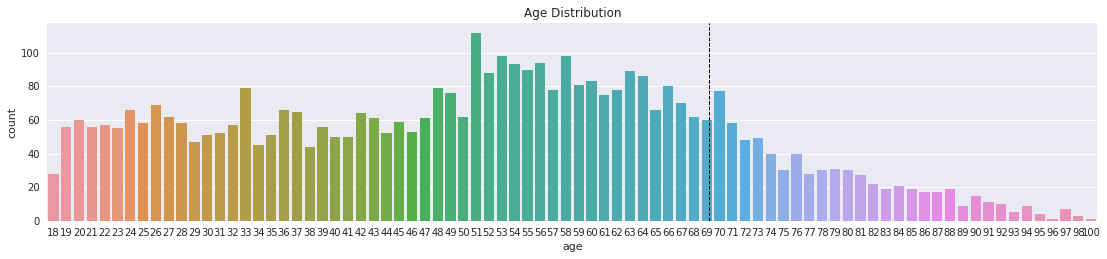

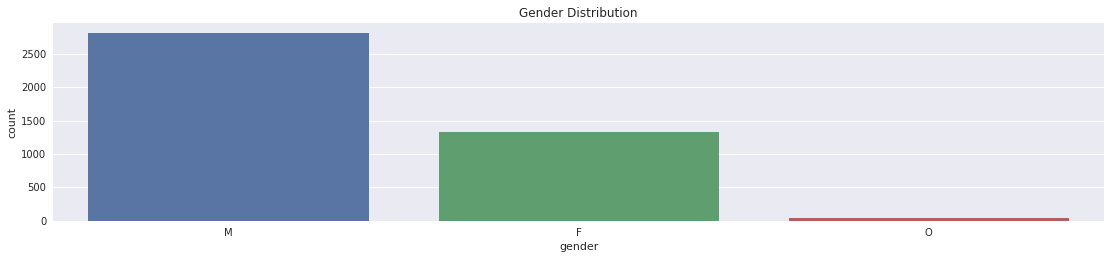

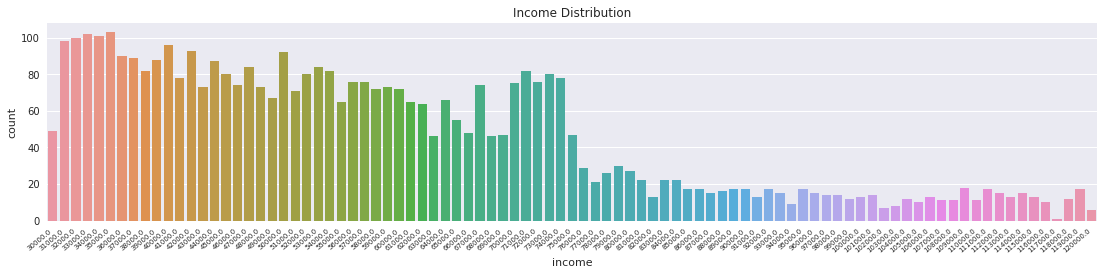

In [218]:
# Analyze Group 3 - Users that receive offers and DO NOT view offers and DO NOT complete offers
unique_profiles_group3 = get_profiles(demo_df, 1, 0, 0)
show_plots(unique_profiles_group3)


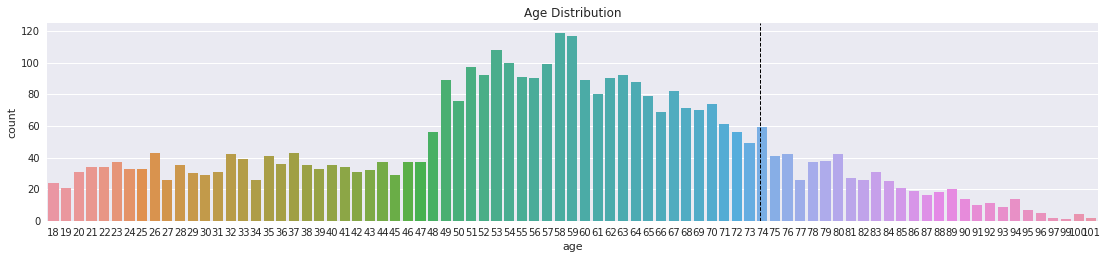

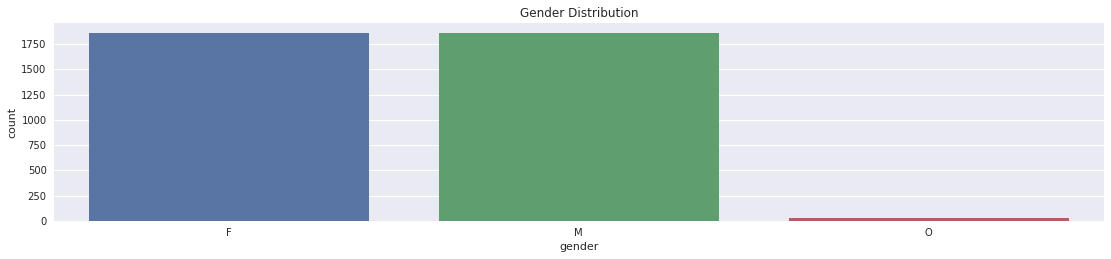

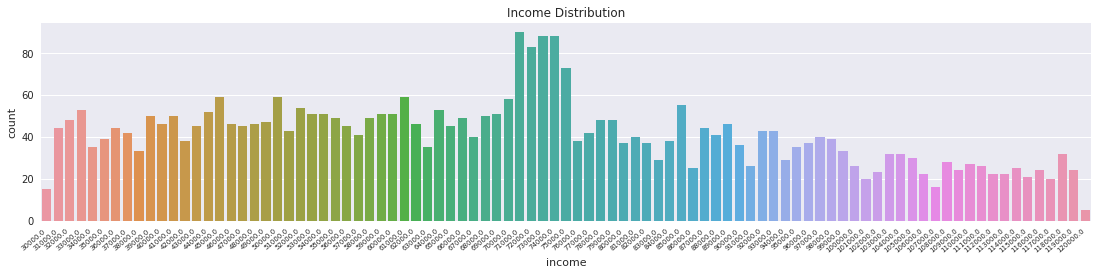

In [219]:
# Analyze Group 4 - Users that receive offers and DO NOT view offers and complete offers
unique_profiles_group4 = get_profiles(demo_df, 1, 0, 1)
show_plots(unique_profiles_group4)

In [220]:
# Print summary stats for each of the above 4 groups
def print_summary(unique_profiles, i):
    '''
    INPUT: 
    unique_profiles - (pandas dataframe) the dataframe containing unique profiles of users with demographics
    i - (int) indicates group number
    
    OUTPUT:
    None
    
    Description:
    Prints summary stats for a given group of users
    
    '''
    print('Group ',i, ' size: ', unique_profiles.shape[0])
    print('Group ', i, ' - Top Ages: \n', unique_profiles['age'].value_counts().head(3))
    print('Group ', i, ' - Average Age: \n', unique_profiles['age'].mean())
    print('Group ', i, ' - Top Gender: \n', unique_profiles['gender'].value_counts().head(1))
    print('Group ', i, ' - Top Income: \n', unique_profiles['income'].value_counts().head(3))
    print('Group ', i, ' - Average Income: \n', unique_profiles['income'].mean())
    
    
print_summary(unique_profiles_group1, 1)
print_summary(unique_profiles_group2, 2)
print_summary(unique_profiles_group3, 3)
print_summary(unique_profiles_group4, 4)

Group  1  size:  11452
Group  1  - Top Ages: 
 58    330
53    304
54    292
Name: age, dtype: int64
Group  1  - Average Age: 
 55.2326231226
Group  1  - Top Gender: 
 M    6105
Name: gender, dtype: int64
Group  1  - Top Income: 
 72000.0    246
73000.0    246
71000.0    235
Name: income, dtype: int64
Group  1  - Average Income: 
 67964.7223192
Group  2  size:  6872
Group  2  - Top Ages: 
 51    174
58    168
60    158
Name: age, dtype: int64
Group  2  - Average Age: 
 52.3787834692
Group  2  - Top Gender: 
 M    4600
Name: gender, dtype: int64
Group  2  - Top Income: 
 57000.0    146
32000.0    145
52000.0    144
Name: income, dtype: int64
Group  2  - Average Income: 
 59991.8509895
Group  3  size:  4183
Group  3  - Top Ages: 
 51    112
53     98
58     98
Name: age, dtype: int64
Group  3  - Average Age: 
 51.1773846522
Group  3  - Top Gender: 
 M    2817
Name: gender, dtype: int64
Group  3  - Top Income: 
 35000.0    103
33000.0    102
34000.0    101
Name: income, dtype: int64
Group

ANALYSIS RESULTS

The insights for Group 4 are the most interesting. Group 4 are the people that receive offers, do not view the offers, and yet end up completing the offers. This means that the offer has no influence on them, they are people who would make purchases regardless. These consumers may be considered as loyal customers. 

Demographic highlights: Group 4 consumers have almost an equal concentration of females as males, although, females lead by a small margin, which is unlike any other groups. Group 4 also has the highest average income of all groups at almost 70,000. 

It may also be helpful to consider a few approaches for this group of customers:

1. Consider changing the offers so they are more lucrative for these types of consumers considering they are more loyal to the brand than others, to see if their offer consumption behavior changes
2. Consider not sending offers to these consumers to save on cost, but monitor to ensure these consumers stay loyal. Explore other engagement channels and methods with these consumers. 

Some other noticeable observations from the results are summarized below:

- Group 3 is the only group that has a higher concentration of income along the lower end of the income scale. 
- Apart from Group 4, Group 1 has a better female to male consumer ratio than Groups 2 and 3 where males dominate for the most part. 
- Looking at group sizes, we see that Group 1 size > Group 2 size > Group 3 size > Group 4 size. It is definitely good news that Group 1 is the largest, where consumers receive, view and complete offers.

CLUSTER ANALYSIS - WHICH USERS REACT BEST TO WHICH OFFER TYPES

Next, I am going to attempt to cluster all the users to analyze purchase patterns as well as offer responses. I will be attempting to answer the below questions.

1. Which customer clusters make the most number of purchases and have the largest transaction amounts
2. Which customer clusters complete bogo offers the most
3. Which customer clusters complete discount offers the most
4. Which customer clusters view informational offers the most


In [221]:
# Make a copy of the profile dataset to start building our dataset for clustering
cluster_df = profile_clean.copy()
cluster_df.head() 

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [222]:
user_offers_clean.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,informational
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,informational
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount


In [225]:
# Create columns for bogo, discount and informational offer responses
bogo_offer_recd = []
bogo_offer_viewed = []
bogo_offer_comp = []
discount_offer_recd = []
discount_offer_viewed = []
discount_offer_comp = []
info_offer_recd = []
info_offer_viewed = []

for p in cluster_df['id']:
    person_df = user_offers_clean[user_offers_clean['person'] == p]
    grouped_df = person_df.groupby(['offer_type'])['offer_recd','offer_viewed','offer_comp'].sum().reset_index()
    bogo_r = 0
    bogo_v = 0
    bogo_c = 0
    info_r = 0
    info_v = 0
    disc_r = 0
    disc_v = 0
    disc_c = 0
    for ot in grouped_df['offer_type']:
        if 'bogo' in ot:
            bogo_r = grouped_df[grouped_df['offer_type'] == 'bogo']['offer_recd'].values[0]
            bogo_v = grouped_df[grouped_df['offer_type'] == 'bogo']['offer_viewed'].values[0]
            bogo_c = grouped_df[grouped_df['offer_type'] == 'bogo']['offer_comp'].values[0]
        elif 'discount' in ot:
            disc_r = grouped_df[grouped_df['offer_type'] == 'discount']['offer_recd'].values[0]
            disc_v = grouped_df[grouped_df['offer_type'] == 'discount']['offer_viewed'].values[0]
            disc_c = grouped_df[grouped_df['offer_type'] == 'discount']['offer_comp'].values[0] 
        else:
            info_r = grouped_df[grouped_df['offer_type'] == 'informational']['offer_recd'].values[0]
            info_v = grouped_df[grouped_df['offer_type'] == 'informational']['offer_viewed'].values[0]
    bogo_offer_recd.append(bogo_r)
    bogo_offer_viewed.append(bogo_v)
    bogo_offer_comp.append(bogo_c)
    discount_offer_recd.append(disc_r)
    discount_offer_viewed.append(disc_v)
    discount_offer_comp.append(disc_c)
    info_offer_recd.append(info_r)
    info_offer_viewed.append(info_v)

cluster_df['bogo_offer_recd'] = bogo_offer_recd
cluster_df['bogo_offer_viewed'] = bogo_offer_viewed
cluster_df['bogo_offer_comp'] = bogo_offer_comp
cluster_df['discount_offer_recd'] = discount_offer_recd
cluster_df['discount_offer_viewed'] = discount_offer_viewed
cluster_df['discount_offer_comp'] = discount_offer_comp
cluster_df['info_offer_recd'] = info_offer_recd
cluster_df['info_offer_viewed'] = info_offer_viewed

cluster_df.head()

,age,became_member_on,gender,id,income,bogo_offer_recd,bogo_offer_viewed,bogo_offer_comp,discount_offer_recd,discount_offer_viewed,discount_offer_comp,info_offer_recd,info_offer_viewed
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,1,0,0,0,1,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,3,3,3,0,0,0,1,1
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1,1,1,2,2,1,1,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,2,2,2,2,2,0,0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,2,2,1,1,0


In [226]:
# Create a dataframe with purchase transactions 
purchase_df = transcript_clean[transcript_clean['event'] == 'transaction']
purchase_df.head()

,event,person,time,value,offer_id,amount,user_reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},None,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},None,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},None,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},None,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},None,18.97,NaN


In [227]:
# Create fields for transaction details like total transactions, total amount and average amount
total_trans = []
total_amount = []
avg_amount = []

for p in cluster_df['id']:
    person_df = purchase_df[purchase_df['person'] == p]
    total_trans.append(person_df['event'].count())
    total_amount.append(person_df['amount'].sum())
    avg_amount.append(person_df['amount'].mean())

cluster_df['total_trans'] = total_trans
cluster_df['total_amount'] = total_amount
cluster_df['avg_amount'] = avg_amount

cluster_df.head()

,age,became_member_on,gender,id,income,bogo_offer_recd,bogo_offer_viewed,bogo_offer_comp,discount_offer_recd,discount_offer_viewed,discount_offer_comp,info_offer_recd,info_offer_viewed,total_trans,total_amount,avg_amount
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,1,0,0,0,1,0,3,77.01,25.670000
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,3,3,3,0,0,0,1,1,7,159.27,22.752857
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1,1,1,2,2,1,1,0,3,57.73,19.243333
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,2,2,2,2,2,0,0,3,36.43,12.143333
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,2,2,1,1,0,4,15.62,3.905000


In [228]:
# Get user rewards for completed offers
user_reward_df = transcript_clean[transcript_clean['event'] == 'offer completed']
user_reward_df.head()

,event,person,time,value,offer_id,amount,user_reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0


In [229]:
# Update user rewards
total_user_reward = []
for p in cluster_df['id']:
    person_df = user_reward_df[user_reward_df['person'] == p]
    total_user_reward.append(person_df['user_reward'].sum())
cluster_df['total_user_reward'] = total_user_reward

In [230]:
cluster_df.head()

,age,became_member_on,gender,id,income,bogo_offer_recd,bogo_offer_viewed,bogo_offer_comp,discount_offer_recd,discount_offer_viewed,discount_offer_comp,info_offer_recd,info_offer_viewed,total_trans,total_amount,avg_amount,total_user_reward
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,1,0,0,0,1,0,3,77.01,25.670000,5.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,3,3,3,0,0,0,1,1,7,159.27,22.752857,20.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1,1,1,2,2,1,1,0,3,57.73,19.243333,7.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,2,2,2,2,2,0,0,3,36.43,12.143333,19.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,2,2,1,1,0,4,15.62,3.905000,2.0


In [231]:
# Check for nulls in cluster_df dataset since we cannot have any missing values for clustering
for c in cluster_df.columns.values:
    print(c,': ', cluster_df[c].isnull().sum())

age :  0
became_member_on :  0
gender :  0
id :  0
income :  0
bogo_offer_recd :  0
bogo_offer_viewed :  0
bogo_offer_comp :  0
discount_offer_recd :  0
discount_offer_viewed :  0
discount_offer_comp :  0
info_offer_recd :  0
info_offer_viewed :  0
total_trans :  0
total_amount :  0
avg_amount :  333
total_user_reward :  0


There is only one field with null values - avg_amount field which have 333 values as Nans. Perhaps these are all users that have made no purchases.

In [232]:
cluster_df[cluster_df['avg_amount'].isnull()]['total_trans'].sum()

0

As suspected, these users have no transaction amounts since they have not made any purchases. We will set these Nan values to 0 as well.

In [233]:
cluster_df['avg_amount'] = cluster_df['avg_amount'].fillna(0)

In [234]:
cluster_df.head()

,age,became_member_on,gender,id,income,bogo_offer_recd,bogo_offer_viewed,bogo_offer_comp,discount_offer_recd,discount_offer_viewed,discount_offer_comp,info_offer_recd,info_offer_viewed,total_trans,total_amount,avg_amount,total_user_reward
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,1,0,0,0,1,0,3,77.01,25.670000,5.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,3,3,3,0,0,0,1,1,7,159.27,22.752857,20.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1,1,1,2,2,1,1,0,3,57.73,19.243333,7.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,2,2,2,2,2,0,0,3,36.43,12.143333,19.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,2,2,1,1,0,4,15.62,3.905000,2.0


Next, let's clean up the following fields:

- became_member_on: In order have a good numeric feature for our clustering, I will be cleaning up this field so it can be number of days a user has been a member instead of a date field
- gender: I will be dummy encoding this field since it's categorical
- id: I will be dropping the id field since it's not relevant for clustering and it is an alpha-numeric ID


In [235]:
# Get today's date
todays_date = datetime.datetime.today().strftime('%Y-%m-%d')
todays_yy, todays_mm, todays_dd = todays_date.split('-')

# Find delta between today's date and the became_member_on date 
num_days = []
for d in cluster_df['became_member_on']:
    rec_date = str(d)
    rec_yy = int(rec_date[0:4])
    rec_mm = int(rec_date[4:6])
    rec_dd = int(rec_date[6:8])
    d0 = date(rec_yy, rec_mm, rec_dd)
    d1 = date(int(todays_yy), int(todays_mm), int(todays_dd))
    delta = d1 - d0
    num_days.append(delta.days)
    
cluster_df['num_days'] = num_days

# Drop the original became_member_on field
cluster_df = cluster_df.drop('became_member_on', axis=1)

In [245]:
cluster_df.head()

,age,gender,id,income,bogo_offer_recd,bogo_offer_viewed,bogo_offer_comp,discount_offer_recd,discount_offer_viewed,discount_offer_comp,info_offer_recd,info_offer_viewed,total_trans,total_amount,avg_amount,total_user_reward,num_days,cluster_num
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,1,0,0,0,1,0,3,77.01,25.670000,5.0,623,2
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,3,3,3,0,0,0,1,1,7,159.27,22.752857,20.0,690,2
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,1,1,1,2,2,1,1,0,3,57.73,19.243333,7.0,338,0
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,2,2,2,2,2,0,0,3,36.43,12.143333,19.0,414,1
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,2,2,1,1,0,4,15.62,3.905000,2.0,504,1


In [237]:
# One hot encode the gender field
cluster_df_final = pd.get_dummies(cluster_df, columns=['gender'])

In [238]:
# Drop the id column 
cluster_df_final = cluster_df_final.drop('id', axis=1)
cluster_df_final.head()

,age,income,bogo_offer_recd,bogo_offer_viewed,bogo_offer_comp,discount_offer_recd,discount_offer_viewed,discount_offer_comp,info_offer_recd,info_offer_viewed,total_trans,total_amount,avg_amount,total_user_reward,num_days,gender_F,gender_M,gender_O
1,55,112000.0,1,0,1,0,0,0,1,0,3,77.01,25.670000,5.0,623,1,0,0
3,75,100000.0,3,3,3,0,0,0,1,1,7,159.27,22.752857,20.0,690,1,0,0
5,68,70000.0,1,1,1,2,2,1,1,0,3,57.73,19.243333,7.0,338,0,1,0
8,65,53000.0,2,2,2,2,2,2,0,0,3,36.43,12.143333,19.0,414,0,1,0
12,58,51000.0,0,0,0,2,2,1,1,0,4,15.62,3.905000,2.0,504,0,1,0


We are ready to apply clustering to the cluster_df_final dataset. I will be using KMeans and will iterate over 1 to 20 clusters and see if we can figure out a good number of clusters for our analysis.

In [240]:
# Run kmeans for 1 to 20 number of clusters
centers = []
scores = []
for k in range(1,20):  
    kmeans = KMeans(k)
    model = kmeans.fit(cluster_df_final)
    score = abs(model.score(cluster_df_final))
    centers.append(k)
    scores.append(score)
print(centers)
print(scores)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[6918062168612.0312, 2204292385758.7339, 996290648190.94226, 573683779827.43652, 360454832128.14569, 253252687992.15775, 184444448758.30316, 138867777885.83447, 114113776601.2545, 93466547311.202393, 78208609189.350357, 66350184564.810684, 56057410445.393982, 49114444514.286522, 42771716231.830032, 37617302674.410248, 34773846346.780128, 31050443505.904041, 28819215126.604591]


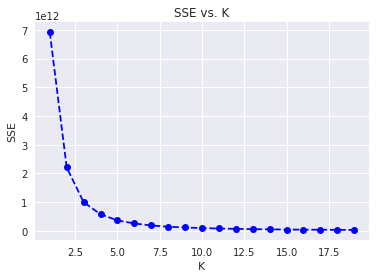

In [241]:
# Plot number of clusters and scores 
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

The rate of change of the scores seems to be slowing down at 4 clusters, so I will be keeping 4 clusters for this analysis.

In [242]:
# Run kmeans with 4 clusters, fit and predict
kmeans = KMeans(4)
model = kmeans.fit(cluster_df_final)
predictions = model.predict(cluster_df_final)

In [243]:
# Assign cluster number predictions to cluster_df
cluster_df['cluster_num'] = predictions

# Get user counts for each cluster
cluster_df.cluster_num.value_counts()

1    4480
0    4276
3    3624
2    2445
Name: cluster_num, dtype: int64

In [252]:
# Explore gender by clusters
cluster_df.groupby(['cluster_num','gender'])['id'].count().reset_index()

,cluster_num,gender,id
0,0,F,2032
1,0,M,2176
2,0,O,68
3,1,F,1615
4,1,M,2793
5,1,O,72
6,2,F,1449
7,2,M,974
8,2,O,22
9,3,F,1033


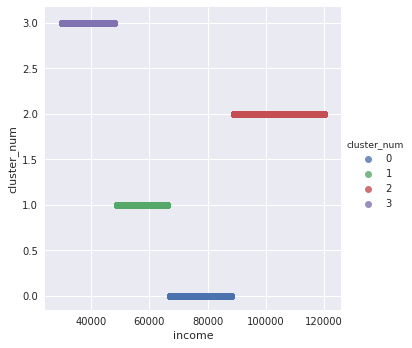

In [253]:
# Visualize income by clusters
plt.figure(figsize = (20,10));
sns.lmplot(x='income', y='cluster_num', hue='cluster_num', data=cluster_df, fit_reg=False);

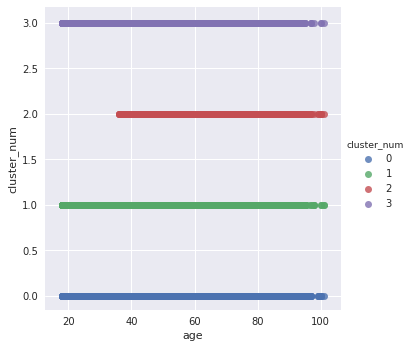

In [254]:
# Visualize age by clusters
plt.figure(figsize = (20,10));
sns.lmplot(x='age', y='cluster_num', hue='cluster_num', data=cluster_df, fit_reg=False);

In [280]:
# Analyze number of transactions, total amount and average amount per transaction by cluster
trans_df = cluster_df.groupby(['cluster_num'])['total_trans','total_amount'].sum().reset_index()
trans_df['avg_amount_per_trans'] = trans_df['total_amount']/trans_df['total_trans']
trans_df

,cluster_num,total_trans,total_amount,avg_amount_per_trans
0,0,31888,597428.85,18.735225
1,1,40543,448131.32,11.053235
2,2,15167,448736.49,29.586371
3,3,36359,240645.74,6.618602


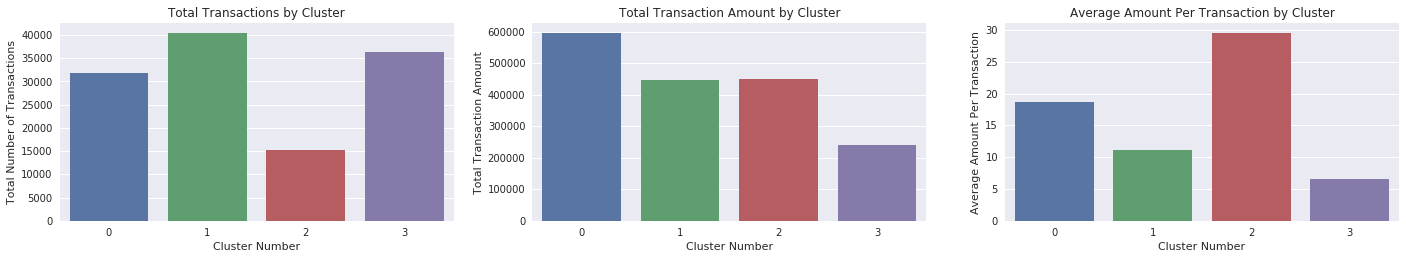

In [289]:
# Visualize transaction details by cluster
f = plt.figure(figsize=(24,8))
axis1 = f.add_subplot(234)
axis1.title.set_text('Total Transactions by Cluster')
sns.barplot(trans_df['cluster_num'], trans_df['total_trans'])
axis1.set(xlabel="Cluster Number", ylabel="Total Number of Transactions")

axis2 = f.add_subplot(235)
axis2.title.set_text('Total Transaction Amount by Cluster')
sns.barplot(trans_df['cluster_num'], trans_df['total_amount'])
axis2.set(xlabel="Cluster Number", ylabel="Total Transaction Amount")

axis3 = f.add_subplot(236)
axis3.title.set_text('Average Amount Per Transaction by Cluster')
sns.barplot(trans_df['cluster_num'], trans_df['avg_amount_per_trans'])
axis3.set(k]kmnnxlabel="Cluster Number", ylabel="Average Amount Per Transaction")

plt.show()

In [290]:
# Explore offer completion and completion rates by cluster
offer_comp_df = cluster_df.groupby(['cluster_num'])['bogo_offer_recd','bogo_offer_viewed','bogo_offer_comp','discount_offer_recd','discount_offer_viewed','discount_offer_comp','info_offer_recd','info_offer_viewed'].sum().reset_index()
offer_comp_df['bogo_comp_rate'] = offer_comp_df['bogo_offer_comp']/offer_comp_df['bogo_offer_recd'] * 100
offer_comp_df['discount_comp_rate'] = offer_comp_df['discount_offer_comp']/offer_comp_df['discount_offer_recd'] * 100
offer_comp_df['info_comp_rate'] = offer_comp_df['info_offer_viewed']/offer_comp_df['info_offer_recd'] * 100
offer_comp_df.head()


,cluster_num,bogo_offer_recd,bogo_offer_viewed,bogo_offer_comp,discount_offer_recd,discount_offer_viewed,discount_offer_comp,info_offer_recd,info_offer_viewed,bogo_comp_rate,discount_comp_rate,info_comp_rate
0,0,6353,5466,4354,6395,4843,4730,3111,2340,68.534551,73.964034,75.216972
1,1,6648,5792,3812,6680,4929,4286,3450,2633,57.340554,64.161677,76.318841
2,2,3630,3000,2825,3642,2681,2917,1840,1312,77.823691,80.093355,71.304348
3,3,5431,4432,2209,5402,3308,2809,2640,1757,40.673909,51.999260,66.553030


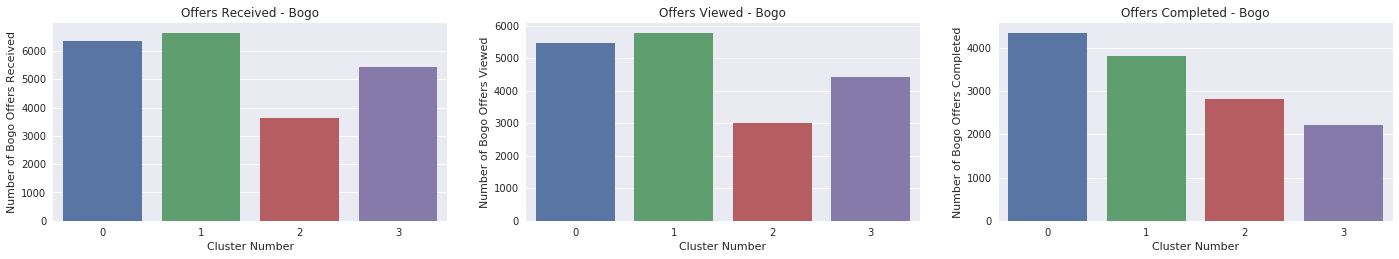

In [293]:
# Visualize offer responses for bogo offers by clusters
f = plt.figure(figsize=(24,8))
axis1 = f.add_subplot(234)
axis1.title.set_text('Offers Received - Bogo')
sns.barplot(trans_df['cluster_num'], offer_comp_df['bogo_offer_recd'])
axis1.set(xlabel="Cluster Number", ylabel="Number of Bogo Offers Received")

axis2 = f.add_subplot(235)
axis2.title.set_text('Offers Viewed - Bogo')
sns.barplot(trans_df['cluster_num'], offer_comp_df['bogo_offer_viewed'])
axis2.set(xlabel="Cluster Number", ylabel="Number of Bogo Offers Viewed")

axis3 = f.add_subplot(236)
axis3.title.set_text('Offers Completed - Bogo')
sns.barplot(trans_df['cluster_num'], offer_comp_df['bogo_offer_comp'])
axis3.set(xlabel="Cluster Number", ylabel="Number of Bogo Offers Completed")

plt.show()

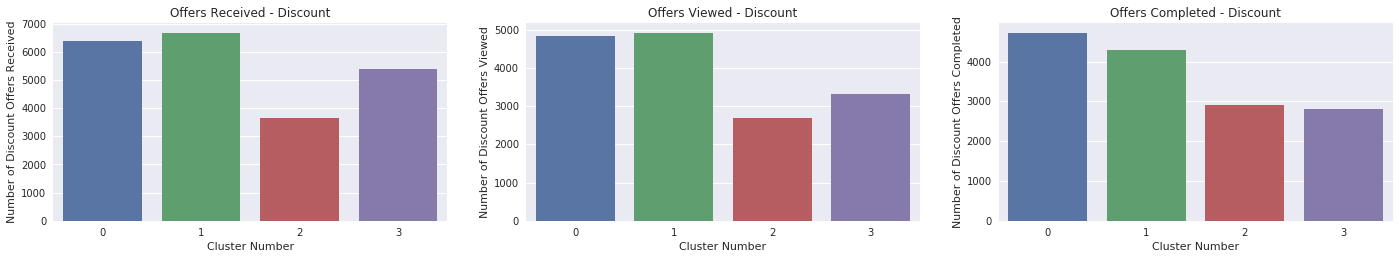

In [294]:
# Visualize offer responses for discount offers by clusters
f = plt.figure(figsize=(24,8))
axis1 = f.add_subplot(234)
axis1.title.set_text('Offers Received - Discount')
sns.barplot(trans_df['cluster_num'], offer_comp_df['discount_offer_recd'])
axis1.set(xlabel="Cluster Number", ylabel="Number of Discount Offers Received")

axis2 = f.add_subplot(235)
axis2.title.set_text('Offers Viewed - Discount')
sns.barplot(trans_df['cluster_num'], offer_comp_df['discount_offer_viewed'])
axis2.set(xlabel="Cluster Number", ylabel="Number of Discount Offers Viewed")

axis3 = f.add_subplot(236)
axis3.title.set_text('Offers Completed - Discount')
sns.barplot(trans_df['cluster_num'], offer_comp_df['discount_offer_comp'])
axis3.set(xlabel="Cluster Number", ylabel="Number of Discount Offers Completed")

plt.show()

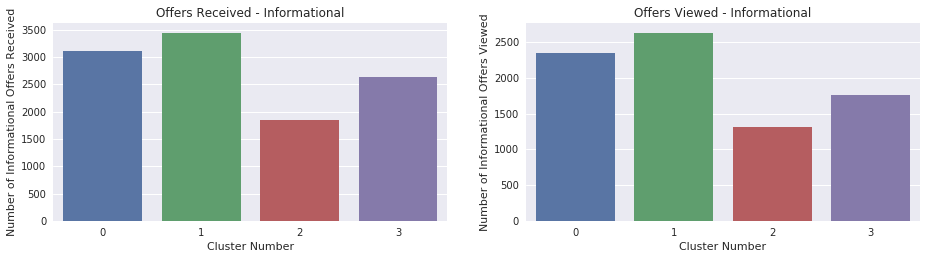

In [295]:
# Visualize offer responses for information offers by clusters
f = plt.figure(figsize=(24,8))
axis1 = f.add_subplot(234)
axis1.title.set_text('Offers Received - Informational')
sns.barplot(trans_df['cluster_num'], offer_comp_df['info_offer_recd'])
axis1.set(xlabel="Cluster Number", ylabel="Number of Informational Offers Received")

axis2 = f.add_subplot(235)
axis2.title.set_text('Offers Viewed - Informational')
sns.barplot(trans_df['cluster_num'], offer_comp_df['info_offer_viewed'])
axis2.set(xlabel="Cluster Number", ylabel="Number of Informational Offers Viewed")

plt.show()

In [302]:
# Analyze completion rates by clusters
comp_rate_df = offer_comp_df[['cluster_num','bogo_comp_rate','discount_comp_rate','info_comp_rate']]
comp_rate_df = pd.melt(comp_rate_df, id_vars="cluster_num", var_name="comp_rate_type", value_name="comp_rate")
comp_rate_df

,cluster_num,comp_rate_type,comp_rate
0,0,bogo_comp_rate,68.534551
1,1,bogo_comp_rate,57.340554
2,2,bogo_comp_rate,77.823691
3,3,bogo_comp_rate,40.673909
4,0,discount_comp_rate,73.964034
5,1,discount_comp_rate,64.161677
6,2,discount_comp_rate,80.093355
7,3,discount_comp_rate,51.999260
8,0,info_comp_rate,75.216972
9,1,info_comp_rate,76.318841


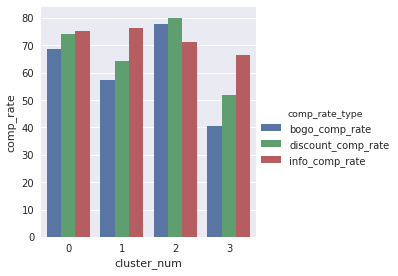

In [306]:
# Plot completion rates by clusters 
sns.factorplot(x='cluster_num', y='comp_rate', hue='comp_rate_type', data=comp_rate_df, kind='bar');